# GA 1.3: Modelling Road Deformation using Non-Linear Least-Squares

<h1 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; top: 60px;right: 30px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png" style="width:100px" />
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png" style="width:100px" />
</h1>
<h2 style="height: 10px">
</h2>

*[CEGM1000 MUDE](http://mude.citg.tudelft.nl/): Week 1.3. Due: Friday, September 20, 2024.*

<div style="background-color:#ffa6a6; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"><p><b>Notes:</b>

- Don't forget to read the "Assignment Context" section of the README, it contains important information to understand this analysis.
- The Markdown questions and answers in this notebook are <em>not</em> graded; they are to help you make observations and describe results, which will eventually go in your <code>Report.md</code>.
</p></div>

In [1]:
import numpy as np
from scipy import interpolate
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt


from functions import *

np.set_printoptions(precision=3)

## Part 0: Dictionary Review

As described above, several functions in this assignment require the use of a Python dictionary to make it easier to keep track of important data, variables and results for the various _models_ we will be constructing and validating.

_It may be useful to revisit PA 1.1, where there was a brief infroduction to dictionaires. That PA contains all the dictionary info you need for GA 1.3. A [read-only copy is here](https://mude.citg.tudelft.nl/2024/files/Week_1_1/PA_1_1_Catch_Them_All.html) and [the source code (notebook) is here](https://gitlab.tudelft.nl/mude/2024-week-1-1)._

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\textbf{Task 0.1}$ 
    
Read and run the cell below to make sure you remember how to use a dictionary.

Modify the function to print some of the other key-value pairs of the dictionary.

<em>It may also be useful to use the cell below when working on later tasks in this assignment.</em>
    
</p>
</div>

In [2]:
my_dictionary = {'key1': 'value1',
                 'key2': 'value2',
                 'name': 'Dictionary Example',
                 'a_list': [1, 2, 3],
                 'an_array': np.array([1, 2, 3]),
                 'a_string': 'hello'
                 }

def function_that_uses_my_dictionary(d):
    print(d['key1'])

    # SOLUTION:
    print(d['name'])
    print(d['a_list'])
    print(d['an_array'])
    print(d['a_string'])

    if 'new_key' in d:
        print('new_key exists and has value:', d['new_key'])
    return

function_that_uses_my_dictionary(my_dictionary)

value1
Dictionary Example
[1, 2, 3]
[1 2 3]
hello


<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\textbf{Task 0.2}$ 

Test your knowledge by adding a new key <code>new_key</code> and then executing the function to print the value.
    
</p>
</div>

In [3]:
# YOUR_CODE_HERE
# function_that_uses_my_dictionary(my_dictionary)

# SOLUTION:
my_dictionary['new_key'] = 'new_value'
function_that_uses_my_dictionary(my_dictionary)

value1
Dictionary Example
[1, 2, 3]
[1 2 3]
hello
new_key exists and has value: new_value


## Task 1: Preparing the data

Within this assignment you will work with two types of data: InSAR data and GNSS data. The cell below will load the data and visualize the observed displacements time. In this task we use the package `pandas`, which is really useful for handling time series. We will learn how to use it later in the quarter; for now, you only need to recognize that it imports the data as a `dataframe` object, which we then convert into a numpy array using the code below.

<div style="background-color:#facb8e; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px"> <p>Tip: note that we have converted all observations to millimeters.</p></div>

In [4]:
gnss = pd.read_csv('./data/gnss_observations.csv')
times_gnss = pd.to_datetime(gnss['times'])
y_gnss = (gnss['observations[m]']).to_numpy()*1000

insar = pd.read_csv('./data/insar_observations.csv')
times_insar = pd.to_datetime(insar['times'])
y_insar = (insar['observations[m]']).to_numpy()*1000

gw = pd.read_csv('./data/groundwater_levels.csv')
times_gw = pd.to_datetime(gw['times'])
y_gw = (gw['observations[mm]']).to_numpy()

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1.1:</b>   
    
Once you have used the cell above to import the data, investigate the data sets using the code cell below. Then provide some relevant summary information in the Markdown cell.

<em>Hint: at the least, you should be able to tell how many data points are in each data set and get an understanding of the mean and standard deviation of each. Make sure you compare the different datasets and use consistent units.</em>
    
</p>
</div>

<div style="background-color:#facb8e; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px"> <p>The code below gives some examples of the quantitative and qualitative ways you could have looked at the data. It is more than you were expected to do; the important thing is that you showed the ability to learn something about the data and describe aspects that are relevant to our problem. We use a dictionary to easily access the different data series using their names, which are entered as the dictionary keys (also not expected of you, but it's hopefully fun to learn useful tricks).</div>

In [5]:
# YOUR_CODE_HERE

# SOLUTION:
data_list = ['y_gnss', 'y_insar', 'y_gw']
data_dict = {data_list[0]: y_gnss,
             data_list[1]: y_insar,
             data_list[2]: y_gw}
def print_summary(data):
    '''Summarize an array with simple print statements.'''
    print('Minimum =     ', data.min())
    print('Maximum =     ', data.max())
    print('Mean =        ', data.mean())
    print('Std dev =     ', data.std())
    print('Shape =       ', data.shape)
    print('First value = ', data[0])
    print('Last value =  ', data[-1])
    print('\n')
          
for item in data_list:
    print('Summary for array: ', item)
    print('------------------------------------------------')
    print_summary(data_dict[item])

Summary for array:  y_gnss
------------------------------------------------
Minimum =      -77.85967600765021
Maximum =      29.432302555465
Mean =         -26.998775875445148
Std dev =      16.2218064476615
Shape =        (730,)
First value =  -13.980633493923001
Last value =   -38.6733705713608


Summary for array:  y_insar
------------------------------------------------
Minimum =      -37.339155096180406
Maximum =      -3.7915269917409
Mean =         -25.459757789872686
Std dev =      6.8998022892131585
Shape =        (61,)
First value =  -3.7915269917409
Last value =   -30.2754656176263


Summary for array:  y_gw
------------------------------------------------
Minimum =      -166.784
Maximum =      -102.044
Mean =         -127.70472
Std dev =      16.822297827633417
Shape =        (25,)
First value =  -109.698
Last value =   -117.268




<Figure size 1500x400 with 0 Axes>

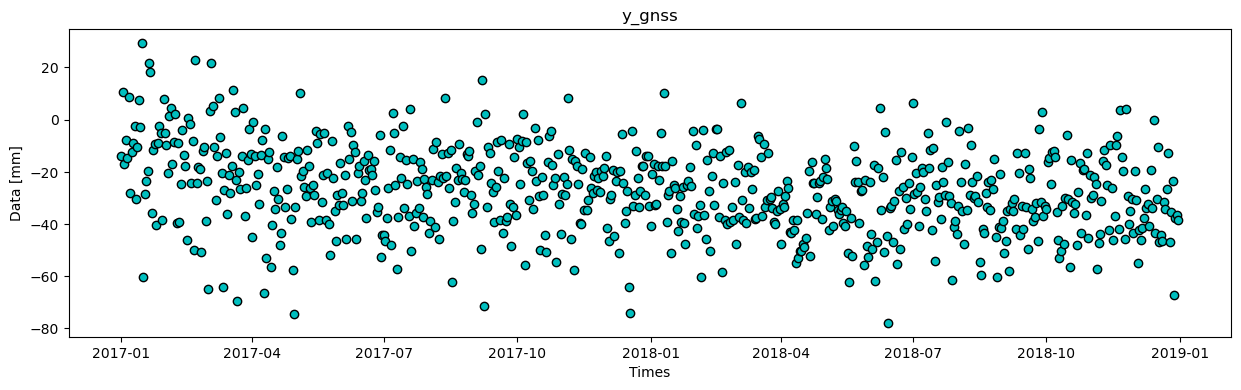

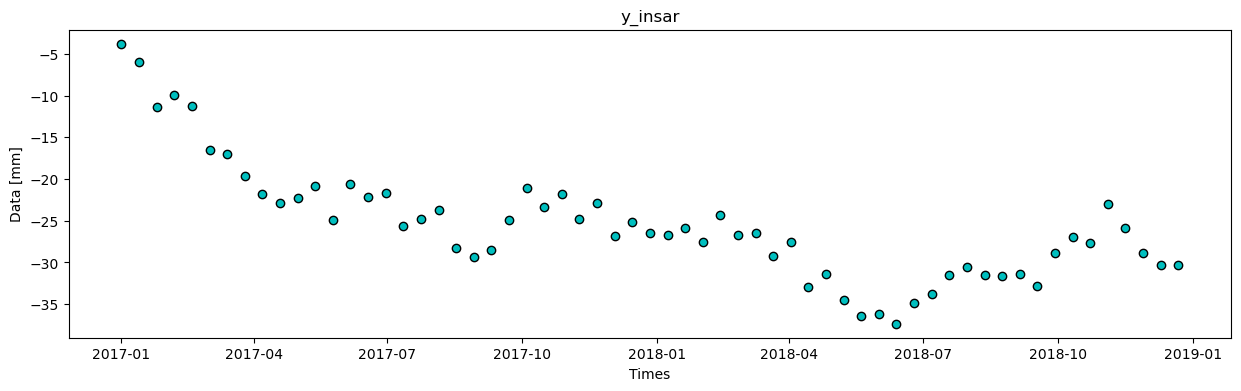

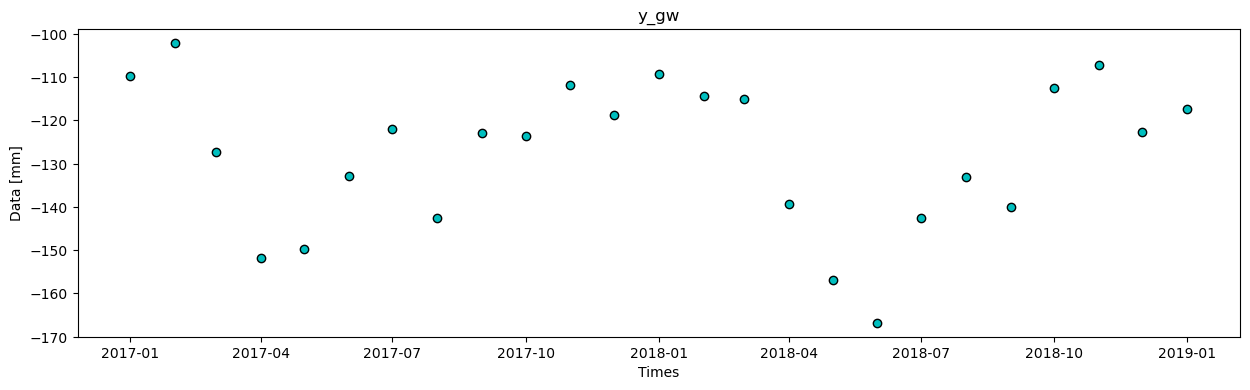

In [30]:
# SOLUTION:
times_dict = {data_list[0]: times_gnss,
              data_list[1]: times_insar,
              data_list[2]: times_gw}
def plot_data(times, data, label):
    plt.figure(figsize=(15,4))
    plt.plot(times, data, 'co', mec='black')
    plt.title(label)
    plt.xlabel('Times')
    plt.ylabel('Data [mm]')
    plt.show()

plt.figure(figsize=(15,4))
for item in data_list:
    plot_data(times_dict[item],
              data_dict[item],
              item)

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\textbf{Solution}$   
    
There are a lot more GNSS data points than InSAR or groundwater. The GNSS observations also have more noise, and what seem to be outliers. In this case the mean and standard deviation do not mean much, because there is clearly a trend with time. We can at least confirm that the time periods of measurements overlap, although the intervals between measurements is certainly not uniform (note that you don't need to do anything with the times, since they are pandas time series and we have not covered them yet).
</p>
</div>

You may have noticed that the groundwater data is available for different times than the GNSS and InSAR data. You will therefore have to *interpolate* the data to the same times for a further analysis. You can use the SciPy function ```interpolate.interp1d``` (read its [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html)).

The cells below do the following:
1. Define a function to convert the time unit
2. Convert the time stamps for all data
3. Use `interp1d` to interpolate the groundwater measurements at the time of the satellite measurements

In [7]:
def to_days_years(times):
    '''Convert the observation times to days and years.'''
    
    times_datetime = pd.to_datetime(times)
    time_diff = (times_datetime - times_datetime[0])
    days_diff = (time_diff / np.timedelta64(1,'D')).astype(int)
    
    days = days_diff.to_numpy()
    years = days/365
    
    return days, years

In [8]:
days_gnss,  years_gnss  = to_days_years(times_gnss)
days_insar, years_insar = to_days_years(times_insar)
days_gw,    years_gw    = to_days_years(times_gw)

interp = interpolate.interp1d(days_gw, y_gw)

GW_at_GNSS_times = interp(days_gnss)
GW_at_InSAR_times = interp(days_insar)

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1.2:</b>   
    
Answer/complete the code and Markdown cells below:
<ol>
    <li>What is <code>interp</code>? (what kind of object is it, and how does it work?)</li>
    <li>How did the groundwater observation array change? Be quantitative. </li>
</ol>
    
</p>
</div>

In [9]:
# YOUR_CODE_HERE

# SOLUTION:
print('array size of GW_at_GNSS_times', len(GW_at_GNSS_times))
print('array size of GW_at_InSAR_times', len(GW_at_InSAR_times))
print('array size of GW before interpolation', len(y_gw))

print('\nFirst values of times_gw:')
print(times_gw[0:2])
print('\nFirst values of y_gw:')
print(y_gw[0:2])
print('\nFirst values of times_gnss:')
print(times_gnss[0:2])
print('\nFirst values of GW_at_GNSS_times:')
print(GW_at_GNSS_times[0:2])

array size of GW_at_GNSS_times 730
array size of GW_at_InSAR_times 61
array size of GW before interpolation 25

First values of times_gw:
0   2017-01-01
1   2017-02-01
Name: times, dtype: datetime64[ns]

First values of y_gw:
[-109.698 -102.044]

First values of times_gnss:
0   2017-01-01
1   2017-01-02
Name: times, dtype: datetime64[ns]

First values of GW_at_GNSS_times:
[-109.698 -109.451]


**Write your answer in this Markdown cell.**

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\textbf{Solution}$
<ol>
    <li><code>interp</code> is a function that will return a value (gw level) for the input(s) (date(s)). The interpolated value is found by linearly interpolating between the two nearest times in the gw observations.</li>
    <li>The observation arrays of <code>GW_at_GNSS_times</code> and <code>GW_at_INSAR_times</code> changed in size to match the size of the GNSS and InSAR observations, respectively.</li>
</ol>  
</p>
</div>

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1.3:</b>   
    
Create a single plot to compare observed displacement for the GNSS and InSAR data sets.
    
</p>
</div>

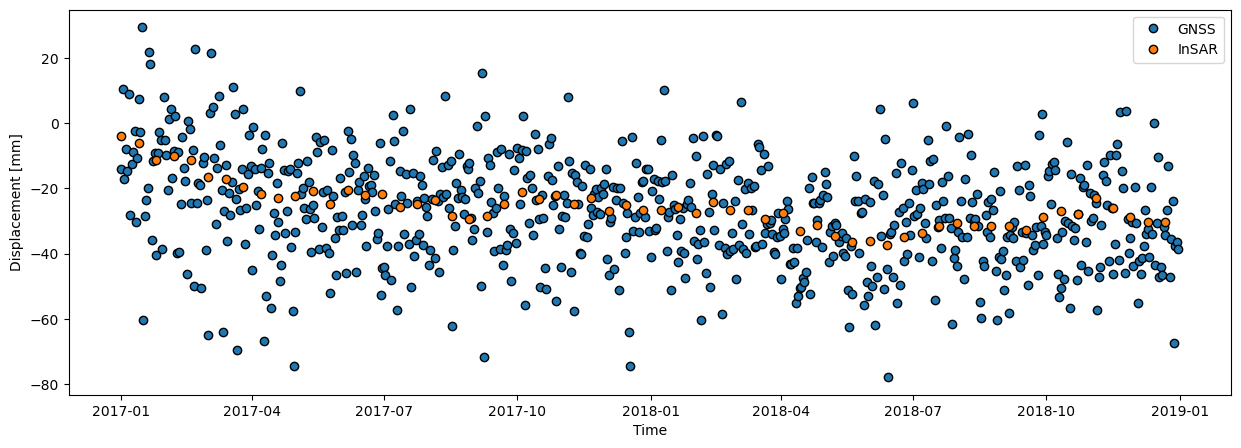

In [10]:
# plt.figure(figsize=(15,5))
# plt.plot(YOUR_CODE_HERE, YOUR_CODE_HERE,
#          'o', mec='black', label = 'GNSS')
# plt.plot(YOUR_CODE_HERE, YOUR_CODE_HERE,
#          'o', mec='black', label = 'InSAR')
# plt.legend()
# plt.ylabel('Displacement [mm]')
# plt.xlabel('Time')
# plt.show()

# SOLUTION:
plt.figure(figsize=(15,5))
plt.plot(times_gnss, y_gnss, 'o', mec='black', label = 'GNSS')
plt.plot(times_insar, y_insar, 'o', mec='black', label = 'InSAR')
plt.legend()
plt.ylabel('Displacement [mm]')
plt.xlabel('Time')
plt.show()

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1.4:</b>   
Describe the datasets based on the figure above and your observations from the previous tasks. What kind of deformation do you see? And what are the differences between both datasets? Be quantitative.
</p>
</div>

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\textbf{Solution}$   
    
The points obviously show subsidence, the displacement shows a similar pattern for both datasets. The GNSS data is much noisier than InSAR (range is around 60 mm versus only a few mm), but has a higher sampling rate. Also there seem to be more outliers in the GNSS data compared to InSAR, especially at the start of the observation period. InSAR has only observations every 6 days but is less noisy. 
</p>
</div>

Before we move on, it is time to do a little bit of housekeeping.

Have you found it confusing to keep track of two sets of variables---one for each data type? Let's use a dictionary to store relevant information about each model. We will use this in the plotting functions for this task (and again next week), so make sure you take the time to see what is happening. Review also Part 0 at the top of this notebook if you need a refresher on dictionaries.

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1.5:</b>   
    
Run the cell below to define a dictionary for storing information about the two (future) models.

</p>
</div>


In [11]:
model_insar = {'data_type': 'InSAR',
               'y':y_insar,
               'times':times_insar,
               'groundwater': GW_at_InSAR_times
               }

model_gnss = {'data_type': 'GNSS',
               'y':y_gnss,
               'times':times_gnss,
               'groundwater': GW_at_GNSS_times
               }

## Task 2: Set-up linear functional model

We want to investigate how we could model the observed displacements of the road. Because the road is built in the Green Heart we expect that the observed displacements are related to the groundwater level. Furthermore, we assume that the displacements can be modeled using a constant velocity. The model is defined as 

$$
d = d_0 + vt + k \ \textrm{GW},
$$

where $d$ is the displacement, $t$ is time and $\textrm{GW}$ is the groundwater level (that we assume to be deterministic). 

Therefore, the model has 3 unknowns:
1. $d_0$, as the initial displacement at $t_0$;
2. $v$, as the displacement velocity;
3. $k$, as the 'groundwater factor', which can be seen as the response of the soil to changes in the groundwater level.


As a group you will construct the **functional model** that is defined as 
$$
\mathbb{E}(Y) = \mathrm{A x}.
$$



<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 2.1:</b>   
    
Construct the design matrix $A$ (for both InSAR and GNSS observations), then show the first 5 observations and confirm the dimensions of $A$.
</p>
</div>

In [12]:
# YOUR_CODE_HERE

# SOLUTION:
A_insar = np.ones((len(times_insar), 3))
A_insar[:,1] = days_insar
A_insar[:,2] = GW_at_InSAR_times

print ('The first 5 rows of the A matrix (InSAR) are:')
print (A_insar[0:5, :])

print ('The first 5 observations [mm] of y_insar are:')
print (y_insar[0:5])

m_insar = np.shape(A_insar)[0]
n_insar = np.shape(A_insar)[1]
print(f'm = {m_insar} and n = {n_insar}')

The first 5 rows of the A matrix (InSAR) are:
[[   1.       0.    -109.698]
 [   1.      12.    -106.735]
 [   1.      24.    -103.772]
 [   1.      36.    -106.536]
 [   1.      48.    -117.316]]
The first 5 observations [mm] of y_insar are:
[ -3.792  -5.999 -11.403  -9.92  -11.283]
m = 61 and n = 3


In [13]:
# YOUR_CODE_HERE

# SOLUTION:
A_gnss = np.ones((len(times_gnss), 3))
A_gnss[:,1] = days_gnss
A_gnss[:,2] = GW_at_GNSS_times

print ('The first 5 rows of the A matrix (GNSS) are:')
print (A_gnss[0:5, :])

print ('\nThe first 5 observations [mm] of y_gnss are:')
print (y_gnss[0:5])

m_gnss = np.shape(A_gnss)[0]
n_gnss = np.shape(A_gnss)[1]
print(f'm = {m_gnss} and n = {n_gnss}')

The first 5 rows of the A matrix (GNSS) are:
[[   1.       0.    -109.698]
 [   1.       1.    -109.451]
 [   1.       2.    -109.204]
 [   1.       3.    -108.957]
 [   1.       4.    -108.71 ]]

The first 5 observations [mm] of y_gnss are:
[-13.981  10.392 -17.091  -7.924 -14.729]
m = 730 and n = 3


<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\textbf{Task 2.2}$
   
Answer the following questions:

- What is the dimension of the observables' vector $Y$?
- What are the unknowns of the functional model?
- What is the redundancy for this model?

</p>
</div>


<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\textbf{Solution}$
    
For InSAR:
<ol>
    <li>The number of observations is 61.</li>
    <li>The number of unknowns is 3.</li>
    <li>The redundancy is 58.</li>
</ol>
    
For GNSS:
<ol>
    <li>The number of observations is 730.</li>
    <li>The number of unknowns is 3.</li>
    <li>The redundancy is 727.</li>
</ol>   
</p>
</div>

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 2.3:</b>   
    
Add the A matrix to the dictionaries for each model. This will be used to plot results later in the notebook.

</p>
</div>


In [14]:
# model_insar['A'] = YOUR_CODE_HERE
# model_gnss['A'] = YOUR_CODE_HERE

# SOLUTION:
model_insar['A'] = A_insar
model_gnss['A'] = A_gnss

print("Keys and Values (type) for model_insar:")
for key, value in model_insar.items():
    print(f"{key:16s} -->    {type(value)}")
print("\nKeys and Values (type) for model_gnss:")
for key, value in model_gnss.items():
    print(f"{key:16s} -->    {type(value)}")

Keys and Values (type) for model_insar:
data_type        -->    <class 'str'>
y                -->    <class 'numpy.ndarray'>
times            -->    <class 'pandas.core.series.Series'>
groundwater      -->    <class 'numpy.ndarray'>
A                -->    <class 'numpy.ndarray'>

Keys and Values (type) for model_gnss:
data_type        -->    <class 'str'>
y                -->    <class 'numpy.ndarray'>
times            -->    <class 'pandas.core.series.Series'>
groundwater      -->    <class 'numpy.ndarray'>
A                -->    <class 'numpy.ndarray'>


## 3. Set-up stochastic model

We will use the Best Linear Unbiased Estimator (BLUE) to solve for the unknown parameters. Therefore we also need a stochastic model, which is defined as
$$
\mathbb{D}(Y) = \Sigma_{Y}.
$$
where $\Sigma_{Y}$ is the covariance matrix of the observables' vector. 




<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 3.1:</b>   
    
Construct the covariance matrix for each type of data and assume that 

- the observables are independent

- the observables are normally distributed

- the observables' standard deviation is
    
    - $\sigma_\textrm{InSAR} = 2$ mm 
    - $\sigma_\textrm{GNSS} = 15$ mm 
    
</p>
</div>


In [15]:
# YOUR_CODE_HERE

# SOLUTION:
std_insar = 2 #mm

Sigma_Y_insar = np.identity(len(times_insar))*std_insar**2

print ('Sigma_Y (InSAR) is defined as:')
print (Sigma_Y_insar)

Sigma_Y (InSAR) is defined as:
[[4. 0. 0. ... 0. 0. 0.]
 [0. 4. 0. ... 0. 0. 0.]
 [0. 0. 4. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 4. 0. 0.]
 [0. 0. 0. ... 0. 4. 0.]
 [0. 0. 0. ... 0. 0. 4.]]


In [16]:
# YOUR_CODE_HERE

# SOLUTION:
std_gnss = 15 #mm (corrected from original value of 5 mm)

Sigma_Y_gnss = np.identity(len(times_gnss))*std_gnss**2

print ('\nSigma_Y (GNSS) is defined as:')
print (Sigma_Y_gnss)


Sigma_Y (GNSS) is defined as:
[[225.   0.   0. ...   0.   0.   0.]
 [  0. 225.   0. ...   0.   0.   0.]
 [  0.   0. 225. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ... 225.   0.   0.]
 [  0.   0.   0. ...   0. 225.   0.]
 [  0.   0.   0. ...   0.   0. 225.]]


<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\textbf{Task 3.2}$
 
Answer the following questions:

- What information is contained in the covariance matrix?
- How do you implement the assumption that all observations are independent?
- What is the dimension of $\Sigma_{Y}$?
- How do you create $\Sigma_{Y}$?

</p>
</div>

_Write your answer in this cell._

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\textbf{Solution}$ 

- The covariance matrix contains information on the quality of the observations, where an entry on the diagonal represents the variance of one observation at a particular epoch. If there is an indication that for instance the quality for a particular time interval differs, different $\sigma$ values can be put in the stochastic model for these epochs. 
- The off-diagonal terms in the matrix are related to the correlation between observations at different epochs, where a zero value on the off-diagonal indicates zero correlation.
- The dimension of the matrix is 61x61 for InSAR and 730x730 for GNSS.
- See code.
</p>
</div>

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 3.3:</b>   
    
Add <code>Sigma_Y</code> to the dictionaries for each model.

</p>
</div>


In [17]:
# model_insar['Sigma_Y] = YOUR_CODE_HERE
# model_gnss['Sigma_Y'] = YOUR_CODE_HERE

# SOLUTION:
model_insar['Sigma_Y'] = Sigma_Y_insar
model_gnss['Sigma_Y'] = Sigma_Y_gnss

## 4. Apply best linear unbiased estimation



<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 4.1:</b>   
    
Write a function to apply BLUE in the cell below and use the function to estimate the unknowns for the model using the data.

Compute the modeled displacements ($\hat{\mathrm{y}}$), and corresponding residuals ($\hat{\mathrm{\epsilon}}$), as well as associated values (as requested by the blank code lines).
</p>
</div>



<div style="background-color:#facb8e; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px"> <p><strong>Note on code implementation</strong>: you'll see that the functions in this assignment use a dictionary; this greatly reduces the number of input/output variables needed in a function. However, it can make the code inside the function more difficult to read due to the key syntax (e.g., <code>dict['variable_1']</code> versus <code>variable
_1</code>). To make this assignment easier for you to implement we have split these functions into three parts: 1) define variables from the dictionary, 2) perform analysis, 3) add results to the dictionary. Note that this is not the most efficient way to write this code; it is done here specifically for clarity and to help you focus on writing the equations properly and understanding the meaning of each term.</p></div>

In [18]:
def BLUE(d):
    """Calculate the Best Linear Unbiased Estimator
    
    Uses dict as input/output:
      - inputs defined from existing values in dict
      - outputs defined as new values in dict
    """

    y = d['y']
    A = d['A']
    Sigma_Y = d['Sigma_Y']

    # Sigma_X_hat = YOUR_CODE_HERE
    # x_hat = YOUR_CODE_HERE
    
    # y_hat = YOUR_CODE_HERE

    # e_hat = YOUR_CODE_HERE

    # Sigma_Y_hat = YOUR_CODE_HERE
    # std_y = YOUR_CODE_HERE

    # Sigma_e_hat = YOUR_CODE_HERE
    # std_e_hat = YOUR_CODE_HERE

    # SOLUTION:
    Sigma_X_hat = np.linalg.inv(A.T @ np.linalg.inv(Sigma_Y) @ A)
    x_hat = Sigma_X_hat @ A.T @ np.linalg.inv(Sigma_Y) @ y
    
    y_hat = A @ x_hat

    e_hat = y - y_hat

    Sigma_Y_hat = A @ Sigma_X_hat @ A.T
    std_Y_hat = np.sqrt(Sigma_Y_hat.diagonal())

    Sigma_e_hat = Sigma_Y - Sigma_Y_hat
    std_e_hat = np.sqrt(Sigma_e_hat.diagonal())

    d['Sigma_X_hat'] = Sigma_X_hat
    d['x_hat'] = x_hat
    d['y_hat'] = y_hat
    d['e_hat'] = e_hat
    d['Sigma_Y_hat'] = Sigma_Y_hat
    d['std_Y_hat'] = std_Y_hat
    d['Sigma_e_hat'] = Sigma_e_hat
    d['std_e_hat'] = std_e_hat

    return d

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 4.2:</b>   
    
Now that you have completed the function, apply it to our two models and then print values for the estimated parameters.
</p>
</div>



In [19]:
model_insar = BLUE(model_insar)
x_hat_insar = model_insar['x_hat']

# YOUR_CODE_HERE

# SOLUTION:
print ('The InSAR-estimated offset is', np.round(x_hat_insar[0],3), 'mm')
print ('The InSAR-estimated velocity is', np.round(x_hat_insar[1],4), 'mm/day')
print ('The InSAR-estimated velocity is', np.round(x_hat_insar[1]*365,4), 'mm/year')
print ('The InSAR-estimated GW factor is', np.round(x_hat_insar[2],3), '[-]\n')

model_gnss = BLUE(model_gnss)
x_hat_gnss = model_gnss['x_hat']

# YOUR_CODE_HERE

# SOLUTION:
print ('The GNSS-estimated offset is', np.round(x_hat_gnss[0],3), 'mm')
print ('The GNSS-estimated velocity is', np.round(x_hat_gnss[1],4), 'mm/day')
print ('The GNSS-estimated velocity is', np.round(x_hat_gnss[1]*365,4), 'mm/year')
print ('The GNSS-estimated GW factor is', np.round(x_hat_gnss[2],3), '[-]')

The InSAR-estimated offset is 9.174 mm
The InSAR-estimated velocity is -0.0243 mm/day
The InSAR-estimated velocity is -8.8667 mm/year
The InSAR-estimated GW factor is 0.202 [-]

The GNSS-estimated offset is 1.181 mm
The GNSS-estimated velocity is -0.0209 mm/day
The GNSS-estimated velocity is -7.615 mm/year
The GNSS-estimated GW factor is 0.16 [-]


<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 4.3:</b>   
Do the values that you just estimated make sense? Explain, using quantitative results.

<em>Hint: all you need to do is use the figures created above to verify that the parameter values printed above are reasonable (e.g., order of magnitude, units, etc).</em> 
</p>
</div>



<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\textbf{Solution}$   
    
As long as the velocity is negative and around -0.02 mm/day or -10 mm/yr it makes sense if you compare with what you see in the plots with observations. Since load is applied on soil layers we expect the road to subside. We also expect to see a positive value for the GW factor.
    
</p>
</div>

## 5. Evaluate the precision



<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 5:</b>   
    
What is the precision of the final estimates? 
    
Print the full covariance matrix of your estimates, and give an interpretation of the numbers in the covariance matrix.
</p>
</div>



In [20]:
Sigma_X_hat_insar = model_insar['Sigma_X_hat']

# YOUR_CODE_HERE

# SOLUTION:
print ('Covariance matrix of estimated parameters (InSAR):')
print (Sigma_X_hat_insar)
print ('\nThe standard deviation for the InSAR-estimated offset is', 
       np.round(np.sqrt(Sigma_X_hat_insar[0,0]),3), 'mm')
print ('The standard deviation for the InSAR-estimated velocity is', 
       np.round(np.sqrt(Sigma_X_hat_insar[1,1]),4), 'mm/day')
print ('The standard deviation for the InSAR-estimated GW factor is', 
       np.round(np.sqrt(Sigma_X_hat_insar[2,2]),3), '[-]\n')

Sigma_X_hat_gnss = model_gnss['Sigma_X_hat']

# YOUR_CODE_HERE

# SOLUTION:
print ('Covariance matrix of estimated parameters (GNSS):')
print (Sigma_X_hat_gnss)
print ('\nThe standard deviation for the GNSS-estimated offset is', 
       np.round(np.sqrt(Sigma_X_hat_gnss[0,0]),3), 'mm')
print ('The standard deviation for the GNSS-estimated velocity is', 
       np.round(np.sqrt(Sigma_X_hat_gnss[1,1]),4), 'mm/day')
print ('The standard deviation for the GNSS-estimated GW factor is', 
       np.round(np.sqrt(Sigma_X_hat_gnss[2,2]),3), '[-]')

Covariance matrix of estimated parameters (InSAR):
[[ 4.530e+00 -4.173e-04  3.363e-02]
 [-4.173e-04  1.472e-06  8.776e-07]
 [ 3.363e-02  8.776e-07  2.646e-04]]

The standard deviation for the InSAR-estimated offset is 2.128 mm
The standard deviation for the InSAR-estimated velocity is 0.0012 mm/day
The standard deviation for the InSAR-estimated GW factor is 0.016 [-]

Covariance matrix of estimated parameters (GNSS):
[[ 2.160e+01 -2.244e-03  1.595e-01]
 [-2.244e-03  6.945e-06  2.238e-06]
 [ 1.595e-01  2.238e-06  1.249e-03]]

The standard deviation for the GNSS-estimated offset is 4.647 mm
The standard deviation for the GNSS-estimated velocity is 0.0026 mm/day
The standard deviation for the GNSS-estimated GW factor is 0.035 [-]


<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\textbf{Solution}$
    
As shown above, the standard deviations of the estimated parameters are equal to the square root of the diagonal elements. Compared with the estimated values, the standard deviations seem quite small, except for the estimated offsets. Meaning that the complete estimated model can be shifted up or down. 
    
The off-diagonal elements show the covariances between the estimated parameters, which are non-zeros since the estimates are all computed as function of the same vector of observations and the same model. A different value for the estimated velocity would imply a different value for the GW factor and offset.  
    
</p>
</div>

## 6. Present and reflect on estimation results

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 6.1:</b>   
    
Complete the function below to help us compute the confidence intervals, then apply the function. Use a confidence interval of 96% in your analysis.

<em>Hint: it can be used in exactly the same way as the <code>BLUE</code> function above, although it has one extra input.</em>
</p>
</div>


In [23]:
def get_CI(d, alpha):
    """Compute the confidence intervals.
    
    Uses dict as input/output:
      - inputs defined from existing values in dict
      - outputs defined as new values in dict
    """

    std_e_hat = d['std_e_hat']
    std_Y_hat = d['std_Y_hat']

    # k = YOUR_CODE_HERE
    # CI_y = YOUR_CODE_HERE
    # CI_res = YOUR_CODE_HERE

    # SOLUTION:
    k = norm.ppf(1 - 0.5*alpha)
    CI_Y_hat = k*std_Y_hat
    CI_res = k*std_e_hat

    d['alpha'] = alpha
    d['CI_Y_hat'] = CI_Y_hat
    d['CI_res'] = CI_res

    return d

In [25]:
# model_insar = YOUR_CODE_HERE
# model_gnss = YOUR_CODE_HERE

# SOLUTION:
model_insar = get_CI(model_insar, 0.04)
model_gnss = get_CI(model_gnss, 0.04)

At this point we have all the important results entered in our dictionary and we will be able to use the plots that have been written for you in the next Tasks. In case you would like to easily see all of the key-value pairs that have been added to the dictionary, you can run the cell below:

In [26]:
print("Keys and Values (type) for model_insar:")
for key, value in model_insar.items():
    print(f"{key:16s} -->    {type(value)}")
print("\nKeys and Values (type) for model_gnss:")
for key, value in model_gnss.items():
    print(f"{key:16s} -->    {type(value)}")

Keys and Values (type) for model_insar:
data_type        -->    <class 'str'>
y                -->    <class 'numpy.ndarray'>
times            -->    <class 'pandas.core.series.Series'>
groundwater      -->    <class 'numpy.ndarray'>
A                -->    <class 'numpy.ndarray'>
Sigma_Y          -->    <class 'numpy.ndarray'>
Sigma_X_hat      -->    <class 'numpy.ndarray'>
x_hat            -->    <class 'numpy.ndarray'>
y_hat            -->    <class 'numpy.ndarray'>
e_hat            -->    <class 'numpy.ndarray'>
Sigma_Y_hat      -->    <class 'numpy.ndarray'>
std_Y_hat        -->    <class 'numpy.ndarray'>
Sigma_e_hat      -->    <class 'numpy.ndarray'>
std_e_hat        -->    <class 'numpy.ndarray'>
alpha            -->    <class 'float'>
CI_Y_hat         -->    <class 'numpy.ndarray'>
CI_res           -->    <class 'numpy.ndarray'>

Keys and Values (type) for model_gnss:
data_type        -->    <class 'str'>
y                -->    <class 'numpy.ndarray'>
times            -->    

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 6.2:</b>   
    
Read the contents of file <code>functions.py</code> and identify what it is doing: you should be able to recognize that they use our model dictionary as an input and create three different figures. Note also that the function to create the figures have already been imported at the top of this notebook.

Use the functions provided to visualize the results of our two models.
</p>
</div>


<div style="background-color:#facb8e; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px"> <p><strong>Note</strong>: remember that you will have to use the same function to look at <em>both</em> models when writing your interpretation in the Report.</p></div>

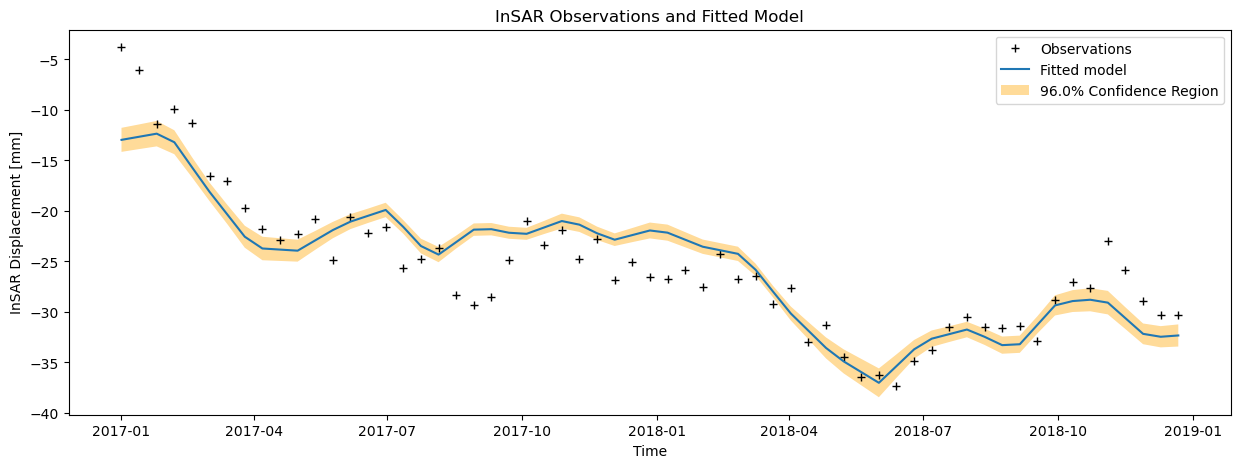

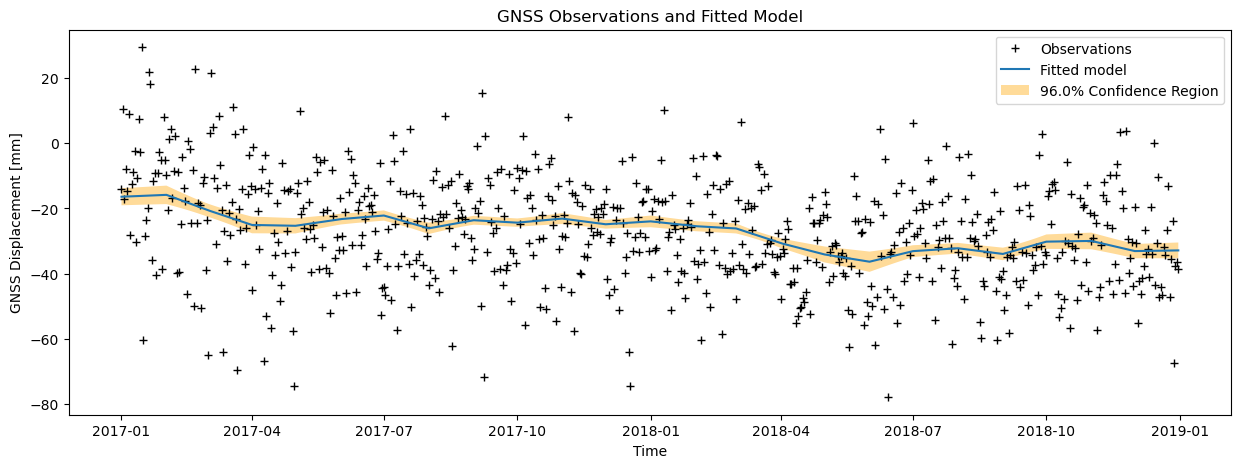

In [27]:
# _, _ = plot_model(YOUR_CODE_HERE)

# SOLUTION:
_, _ = plot_model(model_insar)
_, _ = plot_model(model_gnss)

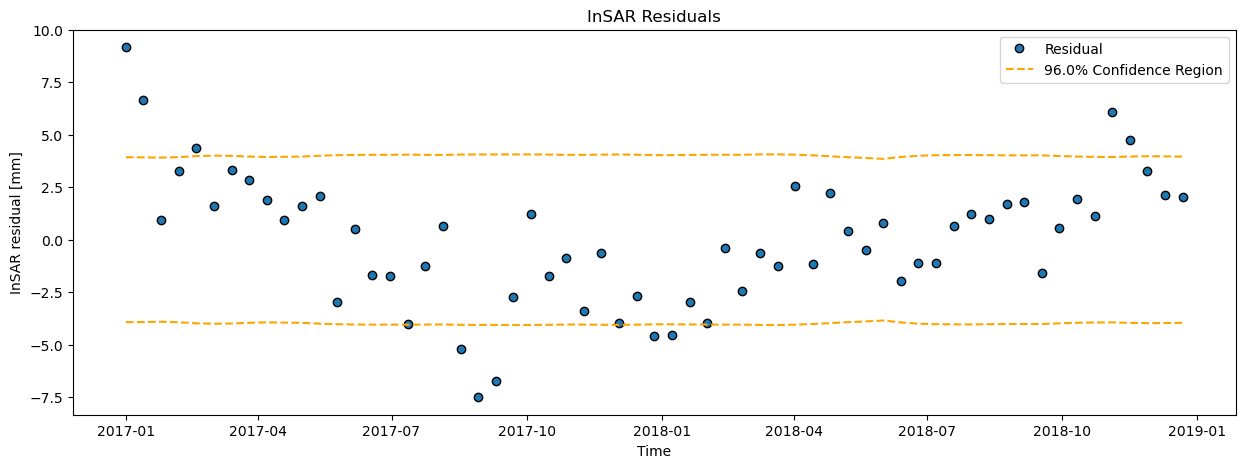

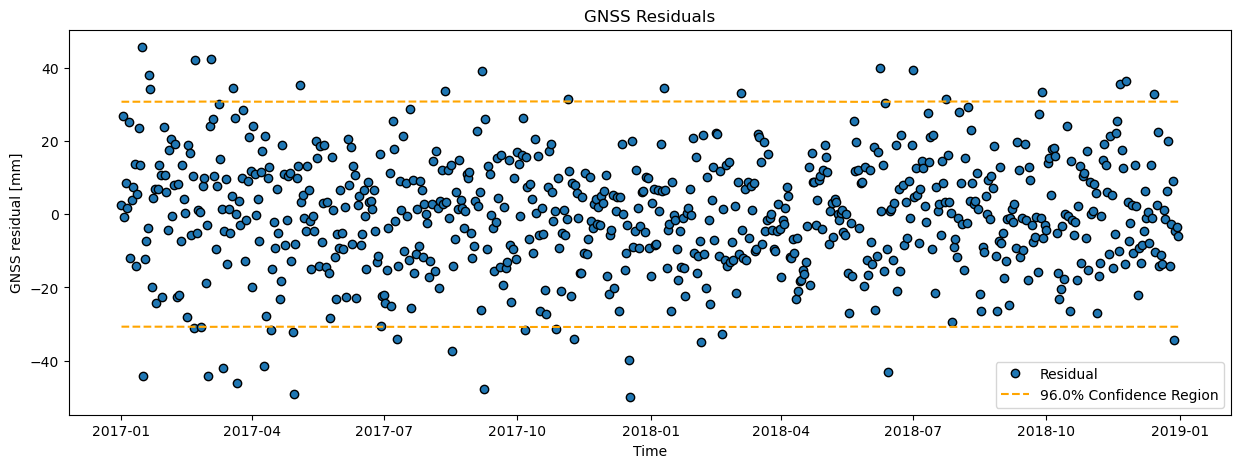

In [28]:
# _, _ = plot_residual(YOUR_CODE_HERE)

# SOLUTION:
_, _ = plot_residual(model_insar)
_, _ = plot_residual(model_gnss)

The mean value of the InSAR residuals is 0.0 mm
The standard deviation of the InSAR residuals is 3.115 mm
The mean value of the GNSS residuals is 0.0 mm
The standard deviation of the GNSS residuals is 15.393 mm


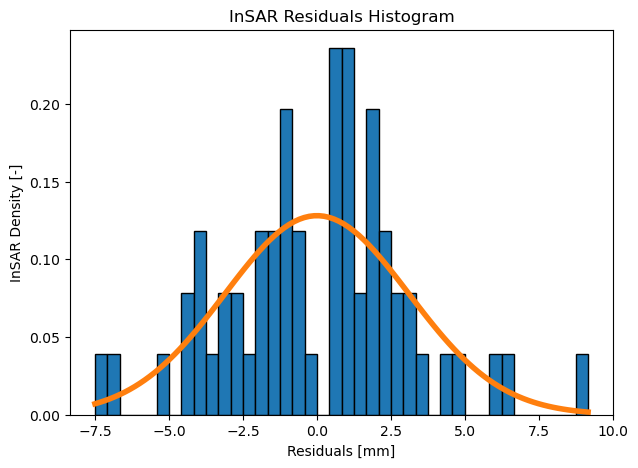

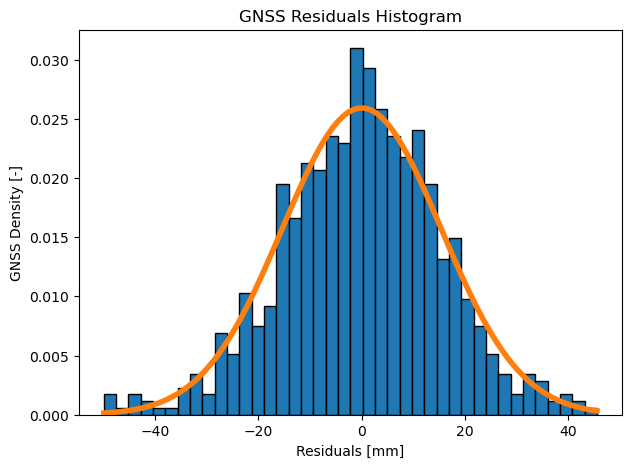

In [26]:
# _, _ = plot_residual_histogram(YOUR_CODE_HERE)

# SOLUTION:
_, _ = plot_residual_histogram(model_insar)
_, _ = plot_residual_histogram(model_gnss)

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\textbf{Solution: the True Model}$
    
The data used in this exercise was generated primarily using Monte Carlo Simulation (but some data were modified "by hand). It is added to the plots here to illustrate where and how our models differ (it is your job to interpret "why").    
</p>
</div>

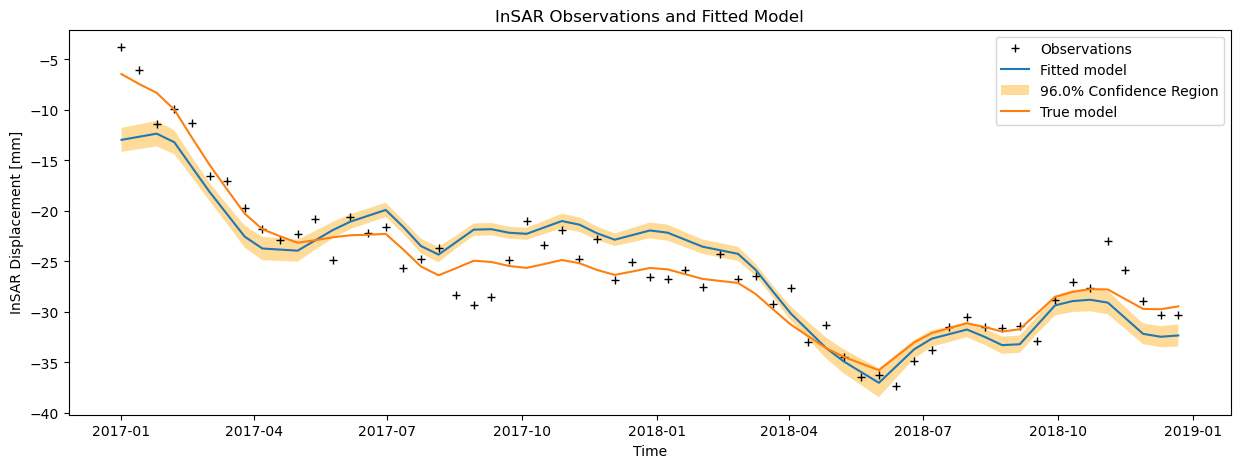

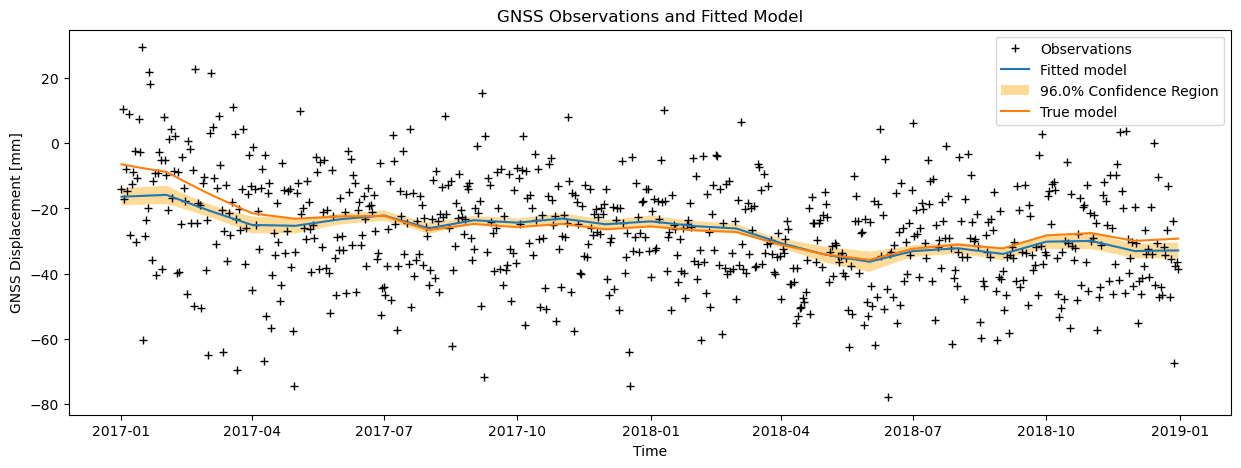

In [27]:
k_true = 0.15
R_true = -22 
a_true = 180
d0_true = 10

disp_insar = (d0_true + R_true*(1 - np.exp(-days_insar/a_true)) +
              k_true*GW_at_InSAR_times)
disp_gnss  = (d0_true + R_true*(1 - np.exp(-days_gnss/a_true)) +
              k_true*GW_at_GNSS_times)

plot_model(model_insar, alt_model=('True model', times_insar, disp_insar));
plot_model(model_gnss, alt_model=('True model', times_gnss, disp_gnss));

**End of notebook.**
<h2 style="height: 60px">
</h2>
<h3 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; bottom: 60px; right: 50px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">
      <img alt="Creative Commons License" style="border-width:; width:88px; height:auto; padding-top:10px" src="https://i.creativecommons.org/l/by/4.0/88x31.png" />
    </a>
    <a rel="TU Delft" href="https://www.tudelft.nl/en/ceg">
      <img alt="TU Delft" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png" />
    </a>
    <a rel="MUDE" href="http://mude.citg.tudelft.nl/">
      <img alt="MUDE" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png" />
    </a>
    
</h3>
<span style="font-size: 75%">
&copy; Copyright 2024 <a rel="MUDE" href="http://mude.citg.tudelft.nl/">MUDE</a> TU Delft. This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">CC BY 4.0 License</a>.